In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from tqdm import tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [4]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(8),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

dataset = datasets.ImageFolder(root="../data", transform=transform)
class_names = dataset.classes
print("Classes:", class_names)

val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=2)


Classes: ['Normal', 'Tuberculosis']


In [5]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


c:\Pratyay\College\Second Year\SIH\SIH-practise\TB\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Pratyay\College\Second Year\SIH\SIH-practise\TB\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\praty/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:09<00:00, 5.15MB/s]


In [7]:
from pathlib import Path

Path("../outputs/checkpoints").mkdir(parents=True, exist_ok=True)


In [8]:
best_acc = 0.0
for epoch in range(10):  # 10 epochs for now
    model.train()
    running_loss = 0.0
    
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/10"):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Validation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    acc = accuracy_score(y_true, y_pred)
    print(f"Epoch {epoch+1}: Loss={running_loss/len(train_loader):.4f}, Val Acc={acc:.4f}")
    
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "../outputs/checkpoints/best_model.pt")
        print("✅ Saved new best model")


Epoch 1/10: 100%|██████████| 210/210 [03:47<00:00,  1.08s/it]


Epoch 1: Loss=0.0936, Val Acc=0.8012
✅ Saved new best model


Epoch 2/10: 100%|██████████| 210/210 [04:42<00:00,  1.35s/it]


Epoch 2: Loss=0.0767, Val Acc=0.9750
✅ Saved new best model


Epoch 3/10: 100%|██████████| 210/210 [04:46<00:00,  1.36s/it]


Epoch 3: Loss=0.0877, Val Acc=0.7214


Epoch 4/10: 100%|██████████| 210/210 [05:31<00:00,  1.58s/it]


Epoch 4: Loss=0.0788, Val Acc=0.9893
✅ Saved new best model


Epoch 5/10: 100%|██████████| 210/210 [04:59<00:00,  1.43s/it]


Epoch 5: Loss=0.0659, Val Acc=0.9560


Epoch 6/10: 100%|██████████| 210/210 [06:12<00:00,  1.77s/it]


Epoch 6: Loss=0.0519, Val Acc=0.9917
✅ Saved new best model


Epoch 7/10: 100%|██████████| 210/210 [05:48<00:00,  1.66s/it]


Epoch 7: Loss=0.0443, Val Acc=0.9952
✅ Saved new best model


Epoch 8/10: 100%|██████████| 210/210 [05:23<00:00,  1.54s/it]


Epoch 8: Loss=0.0344, Val Acc=0.9893


Epoch 9/10: 100%|██████████| 210/210 [29:29<00:00,  8.42s/it]   


Epoch 9: Loss=0.0244, Val Acc=0.9988
✅ Saved new best model


Epoch 10/10: 100%|██████████| 210/210 [03:43<00:00,  1.07s/it]


Epoch 10: Loss=0.0350, Val Acc=0.9726


Best Validation Accuracy: 0.9988095238095238
Classification Report:
               precision    recall  f1-score   support

      Normal       0.99      0.98      0.98       703
Tuberculosis       0.89      0.96      0.92       137

    accuracy                           0.97       840
   macro avg       0.94      0.97      0.95       840
weighted avg       0.97      0.97      0.97       840



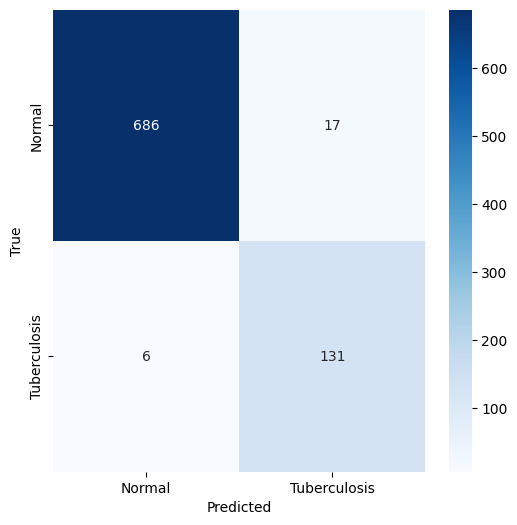

In [9]:
print("Best Validation Accuracy:", best_acc)
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
